In [1]:
%matplotlib inline
import numpy as np
from skyfield.api import load
from scipy.optimize import newton
from matplotlib import pyplot as plt
import plotly
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
from footprint import *
from tno_models import trojan, plutino, twotino
init_notebook_mode(connected=True)
planets = load('de423.bsp')
plotly.tools.set_credentials_file(username='sevenlin123', api_key='vhjhhsCHepMx5oQGJPEp')

In [2]:
#p = plutino(size = 2000, mjd=58199, e_c = 0.3, e_sigma = 0.01, amp_c = 1, amp_max = 2, amp_min = 0)
p = plutino(size = 5000, mjd=57023)

(array([242., 262., 255., 241., 248., 260., 234., 256., 237., 264., 252.,
        234., 264., 232., 265., 255., 259., 270., 224., 242.]),
 array([39.25007392, 39.27006539, 39.29005686, 39.31004833, 39.3300398 ,
        39.35003128, 39.37002275, 39.39001422, 39.41000569, 39.42999717,
        39.44998864, 39.46998011, 39.48997158, 39.50996306, 39.52995453,
        39.549946  , 39.56993747, 39.58992895, 39.60992042, 39.62991189,
        39.64990336]),
 <a list of 20 Patch objects>)

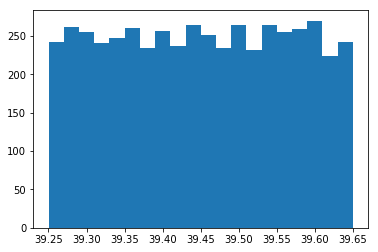

In [3]:
plt.hist(p.a, bins = 20)

(array([ 19.,  35.,  89., 162., 227., 409., 512., 630., 634., 613., 565.,
        428., 286., 201., 109.,  41.,  20.,  13.,   2.,   1.]),
 array([0.0034681 , 0.02324409, 0.04302009, 0.06279609, 0.08257209,
        0.10234808, 0.12212408, 0.14190008, 0.16167608, 0.18145207,
        0.20122807, 0.22100407, 0.24078007, 0.26055606, 0.28033206,
        0.30010806, 0.31988406, 0.33966005, 0.35943605, 0.37921205,
        0.39898805]),
 <a list of 20 Patch objects>)

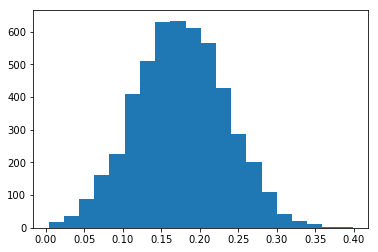

In [4]:
plt.hist(p.e, bins = 20)

(array([248., 686., 928., 933., 773., 576., 377., 228., 117.,  71.,  31.,
         15.,   5.,   4.,   1.,   1.,   1.,   0.,   0.,   1.]),
 array([ 0.17304095,  4.0082848 ,  7.84352865, 11.67877249, 15.51401634,
        19.34926019, 23.18450404, 27.01974789, 30.85499173, 34.69023558,
        38.52547943, 42.36072328, 46.19596712, 50.03121097, 53.86645482,
        57.70169867, 61.53694251, 65.37218636, 69.20743021, 73.04267406,
        76.8779179 ]),
 <a list of 20 Patch objects>)

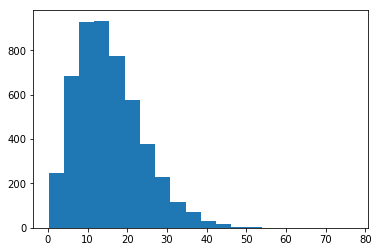

In [5]:
plt.hist(p.i*180/np.pi, bins = 20)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 2.000e+00, 1.000e+01, 1.800e+01, 1.600e+01, 3.400e+01,
        6.000e+01, 8.600e+01, 1.760e+02, 2.490e+02, 4.240e+02, 7.020e+02,
        1.230e+03, 1.983e+03]),
 array([4.48055822, 4.73152756, 4.9824969 , 5.23346624, 5.48443559,
        5.73540493, 5.98637427, 6.23734361, 6.48831295, 6.73928229,
        6.99025163, 7.24122097, 7.49219031, 7.74315965, 7.99412899,
        8.24509833, 8.49606767, 8.74703701, 8.99800635, 9.24897569,
        9.49994503]),
 <a list of 20 Patch objects>)

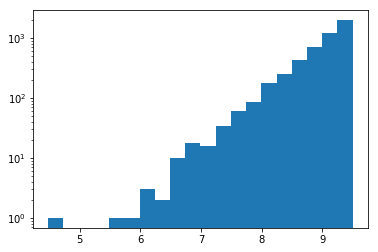

In [6]:
plt.yscale('log')
plt.hist(p.H, bins = 20)

(array([  2.,   2.,   5.,   1.,   8.,  14.,  31.,  42.,  69., 122., 216.,
        343., 462., 615., 708., 696., 683., 599., 323.,  55.]),
 array([20.9726017 , 21.24700785, 21.52141399, 21.79582014, 22.07022628,
        22.34463243, 22.61903857, 22.89344472, 23.16785086, 23.44225701,
        23.71666315, 23.9910693 , 24.26547545, 24.53988159, 24.81428774,
        25.08869388, 25.36310003, 25.63750617, 25.91191232, 26.18631846,
        26.46072461]),
 <a list of 20 Patch objects>)

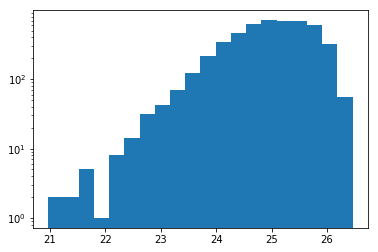

In [7]:
plt.yscale('log')
plt.hist(p.mag_r, bins = 20)

(array([236., 230., 259., 266., 249., 213., 274., 251., 275., 211., 238.,
        241., 283., 267., 267., 262., 241., 241., 231., 261.]),
 array([1.03452506e-03, 6.28955981e-01, 1.25687744e+00, 1.88479889e+00,
        2.51272035e+00, 3.14064180e+00, 3.76856326e+00, 4.39648471e+00,
        5.02440617e+00, 5.65232763e+00, 6.28024908e+00, 6.90817054e+00,
        7.53609199e+00, 8.16401345e+00, 8.79193490e+00, 9.41985636e+00,
        1.00477778e+01, 1.06756993e+01, 1.13036207e+01, 1.19315422e+01,
        1.25594636e+01]),
 <a list of 20 Patch objects>)

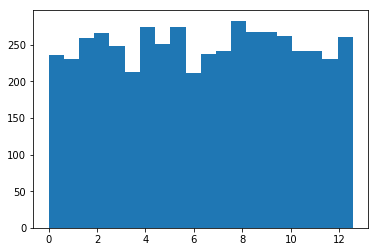

In [8]:
plt.hist(p.M, bins = 20)

(array([264., 259., 246., 260., 248., 217., 245., 247., 254., 238., 259.,
        261., 278., 232., 232., 257., 268., 245., 245., 241.]),
 array([2.23341559e-03, 3.16243766e-01, 6.30254117e-01, 9.44264468e-01,
        1.25827482e+00, 1.57228517e+00, 1.88629552e+00, 2.20030587e+00,
        2.51431622e+00, 2.82832657e+00, 3.14233692e+00, 3.45634727e+00,
        3.77035762e+00, 4.08436797e+00, 4.39837833e+00, 4.71238868e+00,
        5.02639903e+00, 5.34040938e+00, 5.65441973e+00, 5.96843008e+00,
        6.28244043e+00]),
 <a list of 20 Patch objects>)

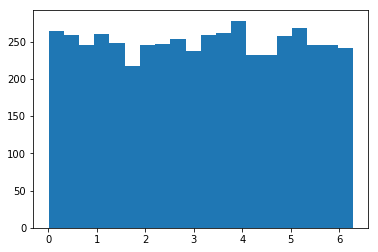

In [9]:
plt.hist(p.arg, bins = 20)

(array([232., 251., 246., 246., 253., 271., 249., 234., 234., 259., 221.,
        261., 246., 243., 258., 289., 243., 283., 232., 245.]),
 array([9.69191113e-04, 3.14990431e-01, 6.29011671e-01, 9.43032911e-01,
        1.25705415e+00, 1.57107539e+00, 1.88509663e+00, 2.19911787e+00,
        2.51313911e+00, 2.82716035e+00, 3.14118159e+00, 3.45520283e+00,
        3.76922407e+00, 4.08324531e+00, 4.39726655e+00, 4.71128779e+00,
        5.02530903e+00, 5.33933027e+00, 5.65335151e+00, 5.96737275e+00,
        6.28139399e+00]),
 <a list of 20 Patch objects>)

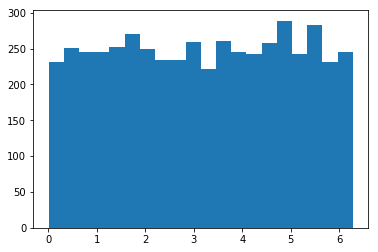

In [10]:
plt.hist(p.node, bins = 20)

(array([242., 256., 264., 247., 260., 242., 259., 271., 221., 253., 240.,
        238., 245., 265., 235., 234., 253., 272., 261., 238.]),
 array([5.82615413e-04, 3.14639123e-01, 6.28695631e-01, 9.42752139e-01,
        1.25680865e+00, 1.57086515e+00, 1.88492166e+00, 2.19897817e+00,
        2.51303468e+00, 2.82709119e+00, 3.14114769e+00, 3.45520420e+00,
        3.76926071e+00, 4.08331722e+00, 4.39737373e+00, 4.71143023e+00,
        5.02548674e+00, 5.33954325e+00, 5.65359976e+00, 5.96765627e+00,
        6.28171277e+00]),
 <a list of 20 Patch objects>)

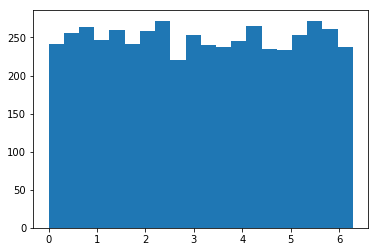

In [11]:
plt.hist((p.arg+p.node) % (2*np.pi), bins = 20)

(array([ 23.,  69.,  95., 156., 250., 316., 370., 398., 402., 431., 456.,
        374., 398., 378., 326., 252., 155.,  86.,  47.,  14.]),
 array([0.59562251, 0.85255392, 1.10948534, 1.36641675, 1.62334816,
        1.88027958, 2.13721099, 2.3941424 , 2.65107382, 2.90800523,
        3.16493664, 3.42186805, 3.67879947, 3.93573088, 4.19266229,
        4.44959371, 4.70652512, 4.96345653, 5.22038795, 5.47731936,
        5.73425077]),
 <a list of 20 Patch objects>)

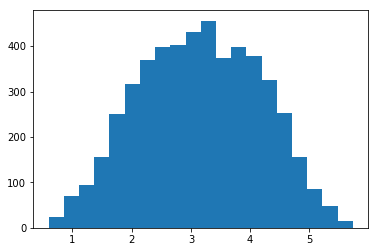

In [12]:
plt.hist(p.phi, bins = 20)

In [13]:
def kep_to_xyz(a, e, i, arg, node, M):
    # compute eccentric anomaly
    f = lambda E, M, e: E - e * np.sin(E) - M
    E0 = M
    E = newton(f, E0, args=(M, e))
    # compute true anomaly
    v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
    # compute the radius
    r = a * (1 - e*np.cos(E))
    # compute X,Y,Z
    X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
    Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
    Z = r * (np.sin(i) * np.sin(arg + v))
    return X, Y, Z

In [14]:
xn, yn, zn = zip(*map(kep_to_xyz, 30+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))
x45, y45, z45 = zip(*map(kep_to_xyz, 45+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))

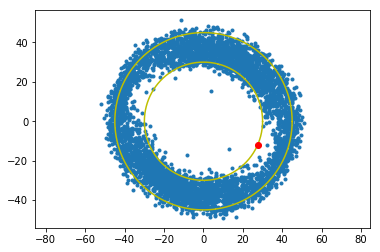

In [15]:
plt.axis('equal')
plt.scatter(p.X,p.Y, marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')
plt.plot(p.x_n, p.y_n, 'ro')

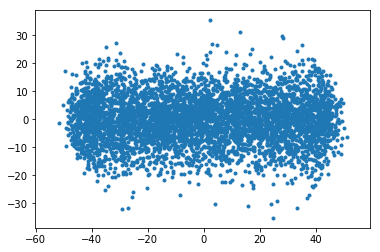

In [16]:
plt.axis('equal')
plt.scatter(p.X,p.Z, marker = '.')

In [17]:
def buildmap(obj_ra, obj_dec, ecliptic_plots=True):
    lon, lat = define_footprint(ecliptic_plots=ecliptic_plots) 
#    lon2, lat2 = define_footprint(polydef='poly_bliss_p9.txt', ecliptic_plots=ecliptic_plots) 
    m = Basemap(lon_0=0, projection='moll', celestial=True)
    x, y = m( lon, lat )
#    x2,y2 = m(lon2, lat2)
    xy = zip(x,y)
#    xy2 = zip(x2,y2)
    foot = patches.Polygon( xy, facecolor='cornflowerblue', edgecolor=None, alpha=0.4 )
#    foot2 = patches.Polygon( xy2, facecolor='lightpink', edgecolor=None, alpha=0.4 )
    plt.gca().add_patch(foot)
#    plt.gca().add_patch(foot2)
    fields = SNfields()
    for f in fields:
        if ecliptic_plots:
            ecl = ephem.Ecliptic(ephem.Equatorial(f.a_ra, f.a_dec))
            lon = ecl.lon if ecl.lon<ephem.degrees('180') else ecl.lon-2*np.pi    
            m.tissot(lon*180/np.pi, ecl.lat*180/np.pi, 1.05, 100, facecolor='g', alpha=0.5)
        else:
            ra = f.a_ra if f.a_ra<ephem.degrees('180') else f.a_ra-2*np.pi
            m.tissot(ra*180/np.pi, f.a_dec*180/np.pi, 1.05, 100, facecolor='r', alpha=0.5)
    obj_ra = obj_ra*180/np.pi
    obj_dec = obj_dec*180/np.pi
    for i in range(len(obj_ra)):
        m.scatter(obj_ra[i], obj_dec[i],3,marker='.',color='k', latlon=True)
    m.drawmapboundary()
    parallels = np.arange(-180.,181,20.)
    m.drawparallels(parallels,labels=[False,True,True,False], alpha=0.4)
    meridians = np.arange(-180.,181.,20.)
    m.drawmeridians(meridians, alpha=0.4)
    return m

In [18]:
#plt.figure(figsize=(20,10))
#m = buildmap(p.ra, p.dec, ecliptic_plots=False)

In [19]:
#plt.figure(figsize=(20,10))
#plt.scatter(p.ra*180/np.pi,p.dec*180/np.pi, marker = '.')

In [20]:
#plutinos = Scatter3d(x=p.X, y=p.Y, z=p.Z, mode='markers', marker=dict(size=1, symbol='circle'), opacity=0.7, name='plutinos')
#sun = Scatter3d(x=0, y=0, z=0, mode='markers', marker=dict(size=10, symbol='circle'), opacity=1, name='Sun')
#neptune = Scatter3d(x=p.x_n, y=p.y_n, z=p.z_n, mode='markers', marker=dict(size=5, symbol='circle'), opacity=0.7, name ='Neptune')
#fig = Figure(data=[plutinos, sun, neptune])
#py.iplot(fig)

In [21]:
t = trojan(size = 5000, mjd=57023)

(array([227., 210., 220., 195., 214., 206., 203., 202., 205., 233., 218.,
        217., 191., 214., 192., 209., 210., 193., 206., 213.]),
 array([29.90016618, 29.91265365, 29.92514112, 29.93762859, 29.95011606,
        29.96260353, 29.975091  , 29.98757847, 30.00006594, 30.0125534 ,
        30.02504087, 30.03752834, 30.05001581, 30.06250328, 30.07499075,
        30.08747822, 30.09996569, 30.11245316, 30.12494063, 30.1374281 ,
        30.14991557]),
 <a list of 20 Patch objects>)

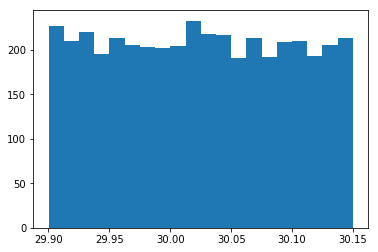

In [22]:
plt.hist(t.a, bins = 20)

(array([305., 339., 404., 424., 425., 445., 398., 331., 300., 239., 168.,
        139.,  84.,  68.,  49.,  29.,  19.,   8.,   3.,   1.]),
 array([6.02430168e-05, 8.86100912e-03, 1.76617752e-02, 2.64625413e-02,
        3.52633074e-02, 4.40640735e-02, 5.28648396e-02, 6.16656057e-02,
        7.04663718e-02, 7.92671379e-02, 8.80679040e-02, 9.68686701e-02,
        1.05669436e-01, 1.14470202e-01, 1.23270968e-01, 1.32071735e-01,
        1.40872501e-01, 1.49673267e-01, 1.58474033e-01, 1.67274799e-01,
        1.76075565e-01]),
 <a list of 20 Patch objects>)

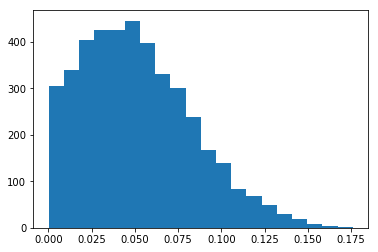

In [23]:
plt.hist(t.e, bins = 20)

(array([157., 416., 547., 649., 622., 530., 425., 306., 216., 124.,  77.,
         52.,  33.,  13.,   6.,   3.,   1.,   0.,   0.,   1.]),
 array([0.00415676, 0.05878535, 0.11341395, 0.16804254, 0.22267114,
        0.27729973, 0.33192833, 0.38655692, 0.44118552, 0.49581412,
        0.55044271, 0.60507131, 0.6596999 , 0.7143285 , 0.76895709,
        0.82358569, 0.87821429, 0.93284288, 0.98747148, 1.04210007,
        1.09672867]),
 <a list of 20 Patch objects>)

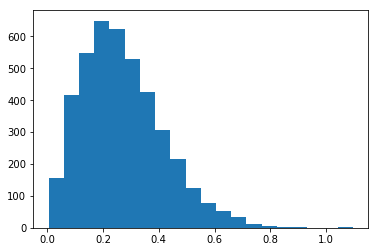

In [24]:
plt.hist(t.i, bins = 20)

(array([ 60., 150., 219., 308., 370., 381., 403., 329., 351., 288., 222.,
        242., 198., 179., 144., 120.,  99.,  56.,  45.,  14.]),
 array([ 5.26717815,  6.24420338,  7.22122861,  8.19825384,  9.17527906,
        10.15230429, 11.12932952, 12.10635475, 13.08337998, 14.0604052 ,
        15.03743043, 16.01445566, 16.99148089, 17.96850611, 18.94553134,
        19.92255657, 20.8995818 , 21.87660703, 22.85363225, 23.83065748,
        24.80768271]),
 <a list of 20 Patch objects>)

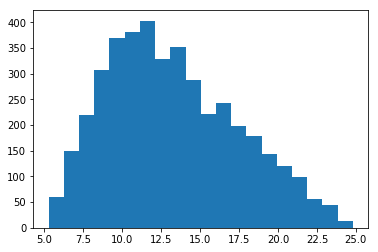

In [25]:
plt.hist(t.amp*180/np.pi, bins = 20)

(array([385., 941., 767.,  31.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,  24., 728., 894., 408.]),
 array([ 12.49992752,  26.90141003,  41.30289255,  55.70437506,
         70.10585757,  84.50734008,  98.90882259, 113.3103051 ,
        127.71178762, 142.11327013, 156.51475264, 170.91623515,
        185.31771766, 199.71920017, 214.12068268, 228.5221652 ,
        242.92364771, 257.32513022, 271.72661273, 286.12809524,
        300.52957775]),
 <a list of 20 Patch objects>)

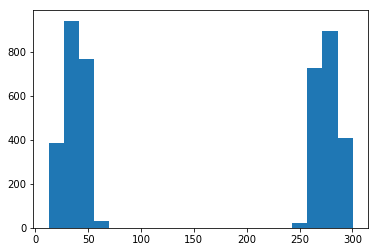

In [26]:
plt.hist((t.phi+t.lambda_N)%(2*np.pi)*180/np.pi, bins = 20)

(array([   2.,    0.,    2.,    2.,    4.,    4.,    8.,    5.,   22.,
          29.,   66.,  110.,  157.,  280.,  475.,  758., 1107.,  895.,
         229.,   23.]),
 array([20.36959076, 20.61727276, 20.86495475, 21.11263675, 21.36031875,
        21.60800075, 21.85568275, 22.10336474, 22.35104674, 22.59872874,
        22.84641074, 23.09409273, 23.34177473, 23.58945673, 23.83713873,
        24.08482073, 24.33250272, 24.58018472, 24.82786672, 25.07554872,
        25.32323072]),
 <a list of 20 Patch objects>)

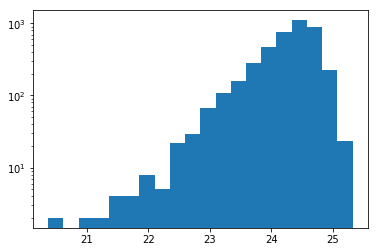

In [27]:
plt.yscale('log')
plt.hist(t.mag_r, bins = 20)

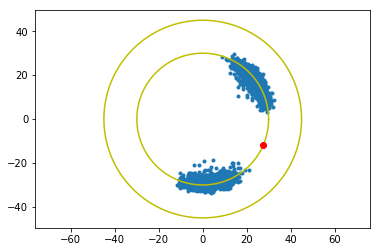

In [28]:
plt.axis('equal')
plt.scatter(t.X,t.Y, marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')
plt.plot(t.x_n, t.y_n, 'ro')

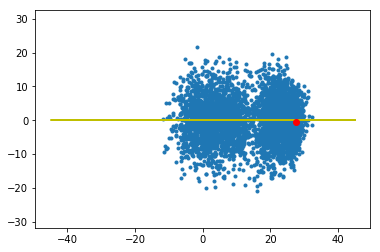

In [29]:
plt.axis('equal')
plt.scatter(t.X,t.Z, marker = '.')
plt.plot(xn, zn, 'y')
plt.plot(x45, z45, 'y')
plt.plot(t.x_n, t.z_n, 'ro')

In [30]:
#trojan = Scatter3d(x=t.X, y=t.Y, z=t.Z, mode='markers', marker=dict(size=1, symbol='circle'), opacity=0.7, name='plutinos')
#sun = Scatter3d(x=0, y=0, z=0, mode='markers', marker=dict(size=10, symbol='circle'), opacity=1, name='Sun')
#neptune = Scatter3d(x=t.x_n, y=t.y_n, z=t.z_n, mode='markers', marker=dict(size=5, symbol='circle'), opacity=0.7, name ='Neptune')
#fig = Figure(data=[trojan, sun, neptune])
#py.iplot(fig)

In [31]:
#plt.figure(figsize=(20,10))
#m = buildmap(t.ra, t.dec, ecliptic_plots=False)

In [32]:
two = twotino(size = 5000, mjd=57023, e_c = 0.4, amp_c = 3, amp_max = 5, amp_min = 0)

(array([272., 311., 384., 337., 333., 360., 236., 145.,  56.,  65.,  47.,
         62., 141., 244., 335., 345., 330., 389., 340., 268.]),
 array([  7.30601877,  22.25607588,  37.206133  ,  52.15619011,
         67.10624723,  82.05630435,  97.00636146, 111.95641858,
        126.90647569, 141.85653281, 156.80658992, 171.75664704,
        186.70670416, 201.65676127, 216.60681839, 231.5568755 ,
        246.50693262, 261.45698973, 276.40704685, 291.35710397,
        306.30716108]),
 <a list of 20 Patch objects>)

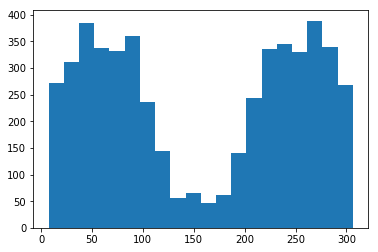

In [33]:
plt.hist((two.phi+two.lambda_N)%(2*np.pi)*180/np.pi, bins = 20)

(array([   2.,    0.,    2.,    2.,    4.,    4.,    8.,    5.,   22.,
          29.,   66.,  110.,  157.,  280.,  475.,  758., 1107.,  895.,
         229.,   23.]),
 array([20.36959076, 20.61727276, 20.86495475, 21.11263675, 21.36031875,
        21.60800075, 21.85568275, 22.10336474, 22.35104674, 22.59872874,
        22.84641074, 23.09409273, 23.34177473, 23.58945673, 23.83713873,
        24.08482073, 24.33250272, 24.58018472, 24.82786672, 25.07554872,
        25.32323072]),
 <a list of 20 Patch objects>)

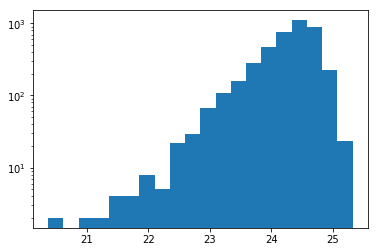

In [34]:
plt.yscale('log')
plt.hist(t.mag_r, bins = 20)

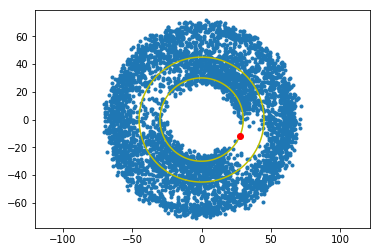

In [36]:
plt.axis('equal')
plt.scatter(two.X,two.Y, marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')
plt.plot(two.x_n, two.y_n, 'ro')

/usr/local/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning:

The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.

/usr/local/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning:

The ishold function was deprecated in version 2.0.

/usr/local/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning:

axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.



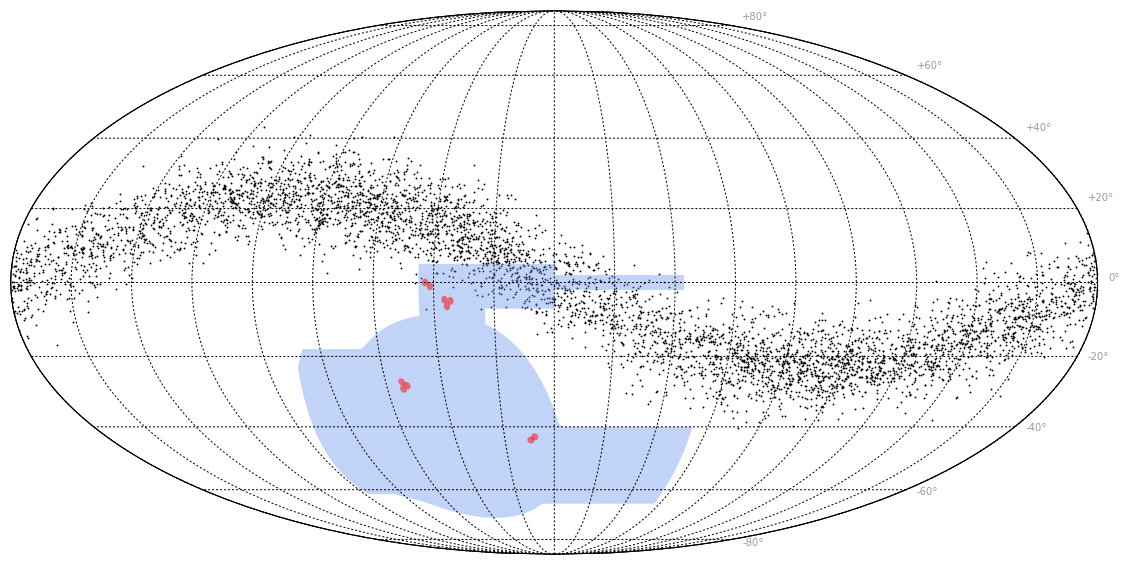

In [40]:
plt.figure(figsize=(20,10))
m = buildmap(two.ra, two.dec, ecliptic_plots=False)

In [38]:
#twotinos = Scatter3d(x=two.X, y=two.Y, z=two.Z, mode='markers', marker=dict(size=1, symbol='circle'), opacity=0.7, name='twotinos')
#sun = Scatter3d(x=0, y=0, z=0, mode='markers', marker=dict(size=10, symbol='circle'), opacity=1, name='Sun')
#neptune = Scatter3d(x=two.x_n, y=two.y_n, z=two.z_n, mode='markers', marker=dict(size=5, symbol='circle'), opacity=0.7, name ='Neptune')
#fig = Figure(data=[twotinos, sun, neptune])
#py.iplot(fig)